In [246]:
import matplotlib.pyplot as plt
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

In [247]:
predictor = TimeSeriesPredictor.load('best_predictor')

In [248]:
# Load data of closing transaction
df = pd.read_csv('../CSV/df_TS_week.csv')
df.head()

,item_id,timestamp,ACT01,ACT03,ACT04,ACT07,ACT09,ACT13,ACT15,ACT17,ACT32,ACT44,target
0,FR13,2019-12-30,1267.0,299.0,0.0,2108.0,189.0,84.0,0.0,0.0,3716.0,0.0,7663.0
1,FR13,2020-01-06,1052.0,490.0,2.0,103.0,255.0,191.0,3.0,0.0,821.0,0.0,2917.0
2,FR13,2020-01-13,846.0,115.0,0.0,280.0,69.0,66.0,416.0,407.0,142.0,0.0,2341.0
3,FR13,2020-01-20,1350.0,932.0,44.0,568.0,297.0,278.0,81.0,80.0,223.0,0.0,3853.0
4,FR13,2020-01-27,1871.0,863.0,0.0,609.0,363.0,219.0,2.0,0.0,19393.0,58931.0,82251.0


In [249]:
# Move 'target' column to the 4 position
cols = list(df.columns)
cols = cols[:2] + cols[-1:] + cols[2:-1]
df = df[cols]

# Show the first 5 rows
df.head()

,item_id,timestamp,target,ACT01,ACT03,ACT04,ACT07,ACT09,ACT13,ACT15,ACT17,ACT32,ACT44
0,FR13,2019-12-30,7663.0,1267.0,299.0,0.0,2108.0,189.0,84.0,0.0,0.0,3716.0,0.0
1,FR13,2020-01-06,2917.0,1052.0,490.0,2.0,103.0,255.0,191.0,3.0,0.0,821.0,0.0
2,FR13,2020-01-13,2341.0,846.0,115.0,0.0,280.0,69.0,66.0,416.0,407.0,142.0,0.0
3,FR13,2020-01-20,3853.0,1350.0,932.0,44.0,568.0,297.0,278.0,81.0,80.0,223.0,0.0
4,FR13,2020-01-27,82251.0,1871.0,863.0,0.0,609.0,363.0,219.0,2.0,0.0,19393.0,58931.0


In [250]:
# Create a new df of the item_id equal to IT01 
df_IT = df[df['item_id'] == 'IT01']

In [251]:
# Split data into training and testing set; train set based on timestamp from 2020-01-01 to 2022-04-30 and test set based on timestamp from 2022-05-01 to 2023-04-30
train_data = df_IT[df_IT['timestamp'] <= '2022-04-30']
test_data = df_IT[df_IT['timestamp'] > '2022-04-30']

# Calculate the percentage of the training set and testing set
print(train_data.shape[0] / df_IT.shape[0])
print(test_data.shape[0] / df_IT.shape[0])

0.6976744186046512
0.3023255813953488


In [252]:
# Convert train_data to TimeSeriesDataFrame
train_data = TimeSeriesDataFrame(
    train_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

train_data.head()

target   ACT01  ACT03  ACT04  ACT07  ACT09  ACT13   ACT15  \
item_id timestamp                                                               
IT01    2019-12-30  7613.0  1228.0   87.0    0.0  195.0  188.0   32.0  1817.0   
        2020-01-06   390.0    87.0   63.0    0.0    5.0    8.0    0.0     0.0   
        2020-01-13   702.0   161.0   10.0    0.0   14.0    0.0   49.0     1.0   
        2020-01-20   941.0   437.0  143.0    0.0   86.0   67.0  110.0     0.0   
        2020-01-27  1470.0   403.0  457.0    0.0  178.0  108.0   48.0     7.0   

                     ACT17   ACT32  ACT44  
item_id timestamp                          
IT01    2019-12-30  1255.0  2811.0    0.0  
        2020-01-06     0.0   227.0    0.0  
        2020-01-13     0.0   467.0    0.0  
        2020-01-20     0.0    98.0    0.0  
        2020-01-27     0.0   269.0    0.0

In [253]:
# Convert test_data to TimeSeriesDataFrame
test_data = TimeSeriesDataFrame(
    test_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

test_data.head()

target  ACT01  ACT03  ACT04  ACT07  ACT09  ACT13  ACT15  \
item_id timestamp                                                             
IT01    2022-05-02  4074.0  788.0   29.0    0.0  396.0   30.0  111.0  515.0   
        2022-05-09   756.0  137.0    0.0    0.0  124.0    0.0    0.0    0.0   
        2022-05-16   439.0  153.0   27.0    0.0   76.0    2.0   24.0    0.0   
        2022-05-23  2078.0  452.0   28.0    0.0  387.0   57.0  158.0  506.0   
        2022-05-30  3883.0  912.0  198.0    0.0  514.0  178.0  261.0   14.0   

                    ACT17   ACT32  ACT44  
item_id timestamp                         
IT01    2022-05-02  145.0  2060.0    0.0  
        2022-05-09    0.0   495.0    0.0  
        2022-05-16    0.0   157.0    0.0  
        2022-05-23  138.0   352.0    0.0  
        2022-05-30   10.0  1796.0    0.0

In [254]:
# Make prediction on training data
predictions = predictor.predict(train_data, model="TemporalFusionTransformer", random_seed=42)
predictions.head()

data with frequency 'None' has been resampled to frequency 'W-MON'.


data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.


mean          0.1          0.2          0.3  \
item_id timestamp                                                        
IT01    2022-05-02  4596.042480  3491.187988  3597.653320  4057.127930   
        2022-05-09  1291.052124   529.667725  1006.255859  1192.847900   
        2022-05-16   917.560059   142.933838   582.590454   701.961060   
        2022-05-23  1178.108032   621.331543   998.502808  1014.724609   
        2022-05-30  3632.099609  2755.543457  2947.647705  3180.537354   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
IT01    2022-05-02  4418.732422  4596.042480  4505.067383  4873.958984   
        2022-05-09  1224.765991  1291.052124  1325.733398  1439.281738   
        2022-05-16   782.897217   917.560059  1064.880005  1193.069092   
        2022-05-23  1138.136353  1178.108032  1164.541504  1235.476807   
        2022-05-30  3463.901855  3632.099609  3505.320801  3772.495117   

                            0.8          0.9  
item_id timestamp                             
IT01    2022-05-02  4969.138184  5375.015625  
        2022-05-09  1644.439575  1967.733154  
        2022-05-16  1298.346558  1662.364868  
        2022-05-23  1371.401245  1568.450439  
        2022-05-30  3761.824219  3793.658936

In [255]:
predictor.leaderboard(test_data)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,NPTS,-0.291218,-0.872810,4.163424,0.038300,0.247416,3
1,DirectTabular,-0.379798,-0.819791,0.153631,0.133528,5.252631,8
2,PatchTST,-0.390760,-0.853419,0.117718,0.029660,274.596578,11
3,DeepAR,-0.444670,-0.945398,0.180793,0.109786,430.833620,9
4,WeightedEnsemble,-0.537652,-0.568749,18.201284,0.050815,13.494215,12
5,TemporalFusionTransformer,-0.544469,-0.568932,0.160440,0.029124,552.889732,10
6,CrostonSBA,-0.836662,-0.905811,18.037336,0.021691,35.869674,2
7,DynamicOptimizedTheta,-0.843813,-0.913061,42.235638,0.241461,50.108401,5
8,AutoETS,-1.245019,-1.040939,35.570082,0.020813,77.332164,4
9,AutoARIMA,-1.490722,-1.239598,24.156501,0.252419,72.727335,6


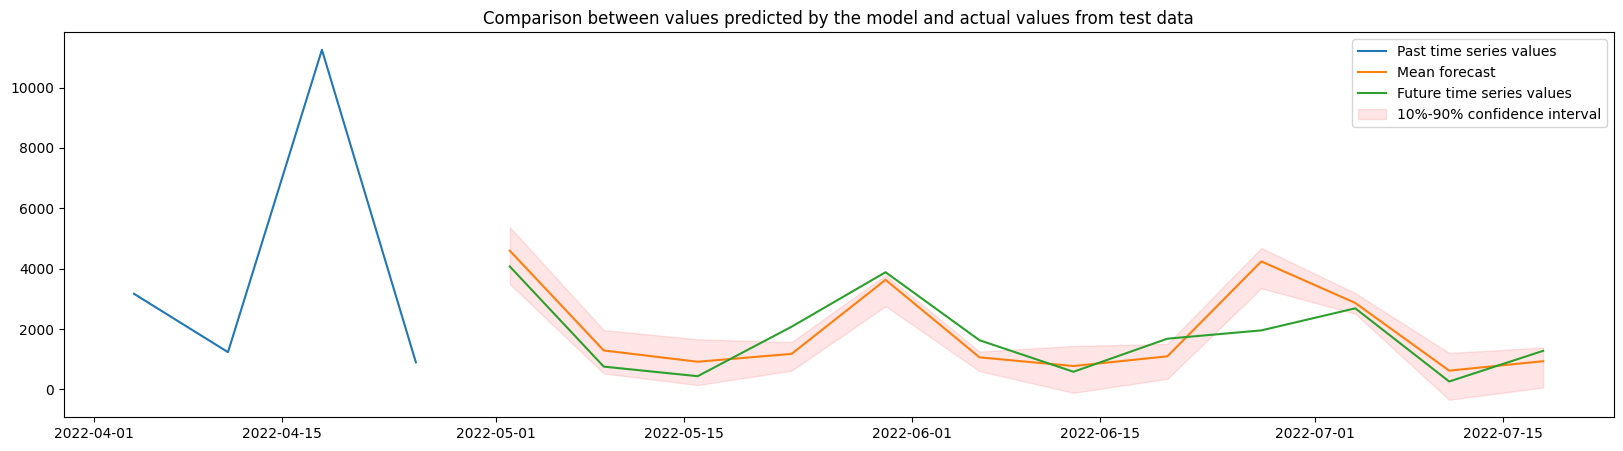

In [260]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data")

item_id = "IT01"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

plt.plot(y_past[-4:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend()

In [257]:
# Sum all value of mean forecast of predictions where item_id is IT01
predictions.loc['IT01']['mean'].sum()

23213.146

In [258]:
# Sum all value of target of test_data 
test_data.loc['IT01']['target'][:12].sum()

21311.0

In [259]:
# Calculate difference betweend each prediction and actual value of test_data
diff = predictions.loc['IT01']['mean'] - test_data.loc['IT01']['target'][:12]
diff

timestamp
2022-05-02     522.042480
2022-05-09     535.052124
2022-05-16     478.560059
2022-05-23    -899.891968
2022-05-30    -250.900391
2022-06-06    -567.307251
2022-06-13     190.050415
2022-06-20    -584.408203
2022-06-27    2284.811035
2022-07-04     178.232910
2022-07-11     359.722168
2022-07-18    -343.815552
dtype: float64